<h3>导入包</h3>

In [74]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

In [75]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])
data_dict

{'二层插座':                      time     value
 0     2013-08-03 00:00:00  0.164062
 1     2013-08-03 00:15:00  0.121094
 2     2013-08-03 00:30:00  0.101562
 3     2013-08-03 00:45:00  0.087891
 4     2013-08-03 01:00:00  0.103516
 ...                   ...       ...
 63395 2015-08-03 22:45:00  0.082031
 63396 2015-08-03 23:00:00  0.128906
 63397 2015-08-03 23:15:00  0.125000
 63398 2015-08-03 23:30:00  0.082031
 63399 2015-08-03 23:45:00  0.160156
 
 [63400 rows x 2 columns], '二层照明':                      time     value
 0     2013-08-03 00:00:00  0.500000
 1     2013-08-03 00:15:00  0.507812
 2     2013-08-03 00:30:00  0.476562
 3     2013-08-03 00:45:00  0.117188
 4     2013-08-03 01:00:00  0.000000
 ...                   ...       ...
 63643 2015-08-03 22:45:00  0.000000
 63644 2015-08-03 23:00:00  0.000000
 63645 2015-08-03 23:15:00  0.000000
 63646 2015-08-03 23:30:00  0.000000
 63647 2015-08-03 23:45:00  0.000000
 
 [63648 rows x 2 columns], '一层插座':                      time     v

<h3>读入天气数据</h3>

In [76]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [77]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63160,2015-08-03 22:45:00,0.082031,0.000000,0.097656,0.250000,2.250000
63161,2015-08-03 23:00:00,0.128906,0.000000,0.175781,0.242188,2.343750
63162,2015-08-03 23:15:00,0.125000,0.000000,0.101562,0.226562,2.093750
63163,2015-08-03 23:30:00,0.082031,0.000000,0.164062,0.171875,2.312500


<h4>将一二层数据相加</h4>

<AxesSubplot:xlabel='time'>

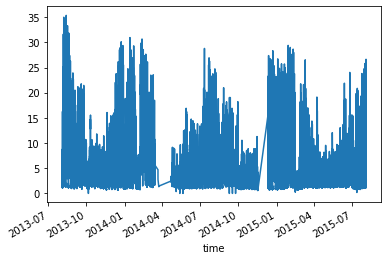

In [78]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
# data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))
data["value_total"].plot()

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [79]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
time,,,,
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-21 18:45:00,1.93750,1.443359,1.316406,4.697266
2014-03-21 19:00:00,1.00000,1.242188,1.320312,3.562500
2014-03-21 19:15:00,0.93750,1.421875,1.304688,3.664062
2014-03-21 19:30:00,1.00000,0.763672,1.023438,2.787109
2014-03-23 19:00:00,0.93750,0.289062,0.179688,1.406250
2014-03-23 19:15:00,0.90625,0.253906,0.171875,1.332031


In [80]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
time,,,,
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125
2014-12-10 17:15:00,11.75000,1.531250,2.019531,15.300781


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [81]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [82]:
# data["value_air"] = data["value_air"].interpolate(method="linear")
# data["value_light"] = data["value_light"].interpolate(method="linear")
# data["value_socket"] = data["value_socket"].interpolate(method="linear")
# data["value_total"] = data["value_total"].interpolate(method="linear")

<h3>按照每小时相加</h3>

In [83]:
data = data.resample("1H").sum()
# data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
# data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
# data = data.dropna()
data

,value_air,value_socket,value_light,value_total
time,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-03 19:00:00,22.593750,1.367188,2.851562,26.812500
2015-08-03 20:00:00,19.281250,1.402344,1.687500,22.371094
2015-08-03 21:00:00,16.312500,1.273438,1.609375,19.195312


<h3>合并天气数据</h3>

In [84]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [85]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [86]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,workday,hour,week,day,month,year
time,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71,0,0,5,3,8,2013
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75,0,1,5,3,8,2013
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54,0,2,5,3,8,2013
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25,0,3,5,3,8,2013
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35,0,4,5,3,8,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1,1,19,0,24,8,2015
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0,1,20,0,24,8,2015
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2,1,21,0,24,8,2015


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [87]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,month,year,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,159,9,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,155,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,150,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,151,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,151,8,...,8,2013,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,43,11,...,8,2015,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,45,9,...,8,2015,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,35,7,...,8,2015,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [88]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,159,9,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,155,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,150,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,43,11,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,45,9,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,35,7,...,0,0,0,1,0,0,0,0,0,0


<h3>构建LightGBM模型</h3>

In [89]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [90]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_score(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [91]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [92]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [93]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

<h4>针对socket构建模型</h4>

<AxesSubplot:xlabel='time'>

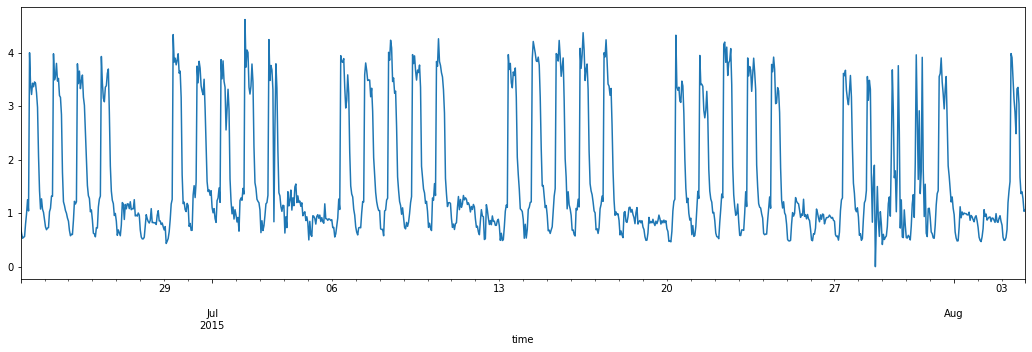

In [94]:
data["value_socket"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

In [95]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-03 23:00:00"]
y_train_socket = data_socket["value_socket"].loc[: "2015-08-03 23:00:00"]
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]

In [96]:
model_socket = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket)
socket_pred = model_socket.predict(x_test_socket)

<AxesSubplot:xlabel='time'>

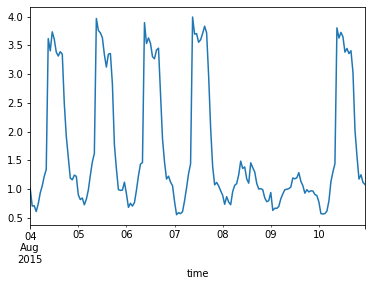

In [97]:
data_socket.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<AxesSubplot:xlabel='time'>

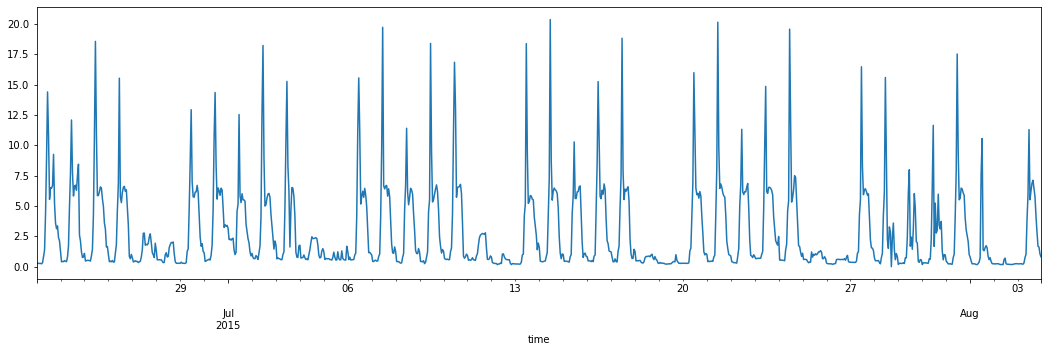

In [98]:
data["value_light"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

In [99]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-03 23:00:00"]
y_train_light = data_light["value_light"].loc[: "2015-08-03 23:00:00"]
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]

In [100]:
model_light = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light)
light_pred = model_light.predict(x_test_light)

<AxesSubplot:xlabel='time'>

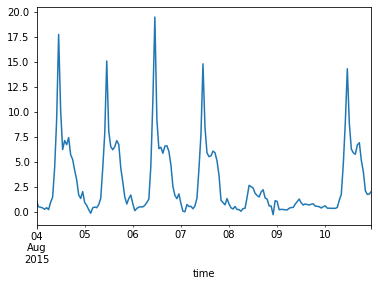

In [101]:
data_light.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<AxesSubplot:xlabel='time'>

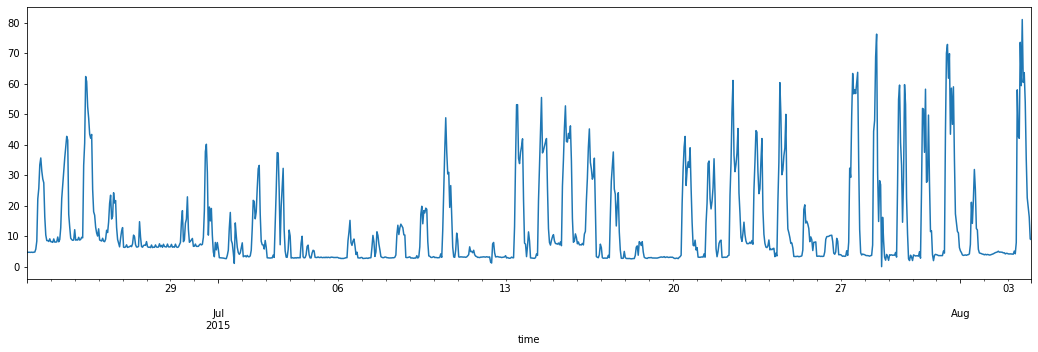

In [102]:
data["value_air"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

In [103]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-03 23:00:00"]
y_train_air = data_air["value_air"].loc[: "2015-08-03 23:00:00"]
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]

In [104]:
model_air = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air)
air_pred = model_air.predict(x_test_air)

<AxesSubplot:xlabel='time'>

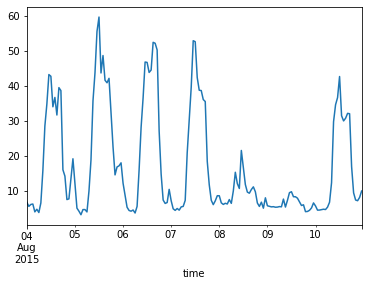

In [105]:
data_air.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<AxesSubplot:xlabel='time'>

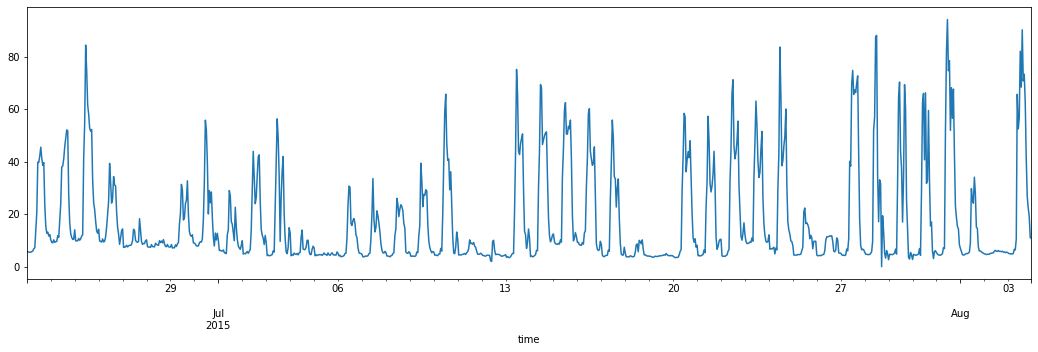

In [106]:
data["value_total"].loc["2015-06-23 00:00:00" : "2015-08-03 23:00:00"].plot(figsize=(18,5))

In [107]:
data_total = data.drop(columns=["value_air", "value_light", "value_socket"])
data_total = data_total[(data_total["value_total"] > 0) | (data_total["value_total"].isnull())]
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-03 23:00:00"]
y_train_total = data_total["value_total"].loc[: "2015-08-03 23:00:00"]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]

In [108]:
sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)
model_total = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total.predict(x_test_total)
total_pred2 = data_total.loc[: "2015-08-03 23:00:00", "value_total"].values[-7*24:]
total_pred = total_pred1 * 0.5 + total_pred2 * 0.5

<AxesSubplot:xlabel='time'>

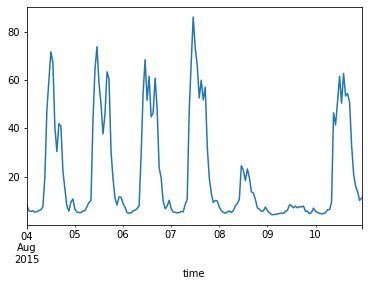

In [109]:
data_total.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"].plot()

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [110]:
results = DataFrame(index=pd.date_range(start="2015-08-04 00:00:00", end="2015-08-10 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-04 00:00:00,8.106615,1.013156,0.980768,6.734997
2015-08-04 01:00:00,5.871009,0.707864,0.469409,5.557494
2015-08-04 02:00:00,5.481676,0.713578,0.426918,6.105355
2015-08-04 03:00:00,5.826903,0.612697,0.362561,6.225344
2015-08-04 04:00:00,5.258518,0.744236,0.222480,3.986586
...,...,...,...,...
2015-08-10 19:00:00,21.159887,1.574388,3.976589,9.430746
2015-08-10 20:00:00,15.921517,1.176799,2.079805,7.371095
2015-08-10 21:00:00,13.665298,1.251589,1.707284,7.174668
2015-08-10 22:00:00,10.089003,1.117862,1.753497,8.123187


In [111]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)